# Modeling: Offer Completion Prediction

**Goal:** Build and compare ML models to predict which customers will complete offers.

**Models to Train:**
1. Logistic Regression (baseline)
2. Decision Tree (baseline)
3. Random Forest (ensemble)
4. XGBoost (ensemble)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Environment ready! ✓")

Environment ready! ✓


## Load Processed Data

In [2]:
processed_dir = '../Cafe_Rewards_Offers/processed'

X_train = joblib.load(f'{processed_dir}/X_train_scaled.pkl')
X_test = joblib.load(f'{processed_dir}/X_test_scaled.pkl')
y_train = joblib.load(f'{processed_dir}/y_train.pkl')
y_test = joblib.load(f'{processed_dir}/y_test.pkl')
feature_names = joblib.load(f'{processed_dir}/feature_names.pkl')
scaler = joblib.load(f'{processed_dir}/scaler.pkl')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")
print(f"\nTarget distribution in train set:")
print(y_train.value_counts(normalize=True).round(3))
print(f"\nTarget distribution in test set:")
print(y_test.value_counts(normalize=True).round(3))

DATA LOADED

Training set: 69,145 samples × 26 features
Test set: 17,287 samples × 26 features

Target distribution in train set:
target
1    0.534
0    0.466
Name: proportion, dtype: float64

Target distribution in test set:
target
1    0.534
0    0.466
Name: proportion, dtype: float64


## 🔍 Check for Data Leakage

**Important:** Perfect metrics (1.0 accuracy) usually indicate data leakage.
Let's check if any features directly reveal the target.

In [3]:
print("="*60)
print("CHECKING FOR DATA LEAKAGE")
print("="*60)

# Check feature names
print(f"\nFeatures ({len(feature_names)} total):")
for i, feat in enumerate(feature_names):
    print(f"  {i:2}. {feat}")

# Check if target has perfect correlation with any feature
print("\n" + "="*60)
print("CHECKING FOR PERFECT CORRELATION")
print("="*60)

# Combine X and y for correlation check
train_df = X_train.copy()
train_df['target'] = y_train.values

# Calculate correlation with target
correlations = train_df.corr()['target'].sort_values(ascending=False)

print("\nTop correlations with target:")
for feat, corr in correlations.head(10).items():
    print(f"  {feat:30}: {corr:.4f}")

# Flag potential data leaks (correlation = 1.0 or near 1.0)
perfect_leaks = correlations[correlations == 1.0]
if len(perfect_leaks) > 0:
    print(f"\n⚠️  DATA LEAKAGE DETECTED!")
    print(f"Features with perfect correlation (r=1.0):")
    for feat in perfect_leaks.index:
        print(f"  - {feat}")
    print("\n⚠️  ACTION REQUIRED: Remove these features before modeling!")
else:
    print("\n✓ No perfect data leaks detected (correlation < 1.0)")

# Check for near-perfect leaks (correlation > 0.95)
near_leaks = correlations[(correlations > 0.95) & (correlations < 1.0)]
if len(near_leaks) > 0:
    print(f"\n⚠️  NEAR-PERFECT DATA LEAKAGE DETECTED!")
    print(f"Features with near-perfect correlation (r > 0.95):")
    for feat, corr in near_leaks.items():
        print(f"  - {feat:30}: {corr:.4f}")

CHECKING FOR DATA LEAKAGE

Features (26 total):
   0. received_time
   1. difficulty
   2. duration
   3. in_email
   4. in_mobile
   5. in_social
   6. in_web
   7. offer_received
   8. offer_viewed
   9. offer_completed
  10. age
  11. income
  12. membership_year
  13. is_demographics_missing
  14. membership_duration_days
  15. membership_month
  16. offer_type_bogo
  17. offer_type_discount
  18. offer_type_informational
  19. gender_F
  20. gender_M
  21. gender_Missing
  22. gender_O
  23. age_group_encoded
  24. income_bracket_encoded
  25. tenure_group_encoded

CHECKING FOR PERFECT CORRELATION

Top correlations with target:
  target                        : 1.0000
  offer_completed               : 1.0000
  duration                      : 0.3518
  income                        : 0.3164
  income_bracket_encoded        : 0.3081
  difficulty                    : 0.2695
  offer_type_discount           : 0.2497
  tenure_group_encoded          : 0.2294
  in_web                       

In [4]:
# ============================================================================
# ADD THIS TO YOUR 03_MODELING.IPYNB
# ============================================================================

# INSTRUCTIONS:
# 1. Create a NEW code cell in your 03_Modeling.ipynb notebook
# 2. Paste this ENTIRE code block into that new cell
# 3. Place it RIGHT AFTER the "Load Processed Data" cell
# ============================================================================

# ============================================================================
# REMOVE DATA LEAKAGE
# ============================================================================

print("=" * 60)
print("CHECKING FOR DATA LEAKAGE")
print("=" * 60)

# Check if offer_completed is in features (THIS IS THE PROBLEM!)
if 'offer_completed' in X_train.columns:
    print("\n" + "=" * 60)
    print("⚠️  DATA LEAKAGE DETECTED!")
    print("=" * 60)
    print("Column 'offer_completed' found in features.")
    print("This is IDENTICAL to target, causing perfect 1.0 predictions.")
    print("Dropping 'offer_completed' from train and test sets...")
    
    X_train.drop('offer_completed', axis=1, inplace=True)
    X_test.drop('offer_completed', axis=1, inplace=True)
    
    print(f"✓ Dropped. New train shape: {X_train.shape}")
    print(f"✓ Features remaining: {len(X_train.columns)}")
else:
    print("\n✓ No 'offer_completed' column found (already removed)")

# Also check for offer_viewed (less severe leak, but worth noting)
if 'offer_viewed' in X_train.columns:
    print("\nℹ️  INFO: 'offer_viewed' feature present")
    print("=" * 60)
    print("This feature is a potential data leak.")
    print("It's available before completion in real-time scenarios.")
    print("For now, we'll keep it to see full model performance.")
    print("=" * 60)
    print("\nRECOMMENDATION:")
    print("For true real-time prediction models, consider:")
    print("  1. Train models WITHOUT 'offer_viewed'")
    print("  2. For 'post-notification' prediction, keep 'offer_viewed'")
    print("\nFor now, we'll keep it to see full model performance.")
else:
    print("✓ No 'offer_viewed' feature found")

# Final verification
print("\n" + "=" * 60)
print("FINAL DATA SHAPE")
print("=" * 60)
print(f"Train: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Test: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")
print(f"Features: {len(X_train.columns)}")


CHECKING FOR DATA LEAKAGE

⚠️  DATA LEAKAGE DETECTED!
Column 'offer_completed' found in features.
This is IDENTICAL to target, causing perfect 1.0 predictions.
Dropping 'offer_completed' from train and test sets...
✓ Dropped. New train shape: (69145, 25)
✓ Features remaining: 25

ℹ️  INFO: 'offer_viewed' feature present
This feature is a potential data leak.
It's available before completion in real-time scenarios.
For now, we'll keep it to see full model performance.

RECOMMENDATION:
For true real-time prediction models, consider:
  1. Train models WITHOUT 'offer_viewed'
  2. For 'post-notification' prediction, keep 'offer_viewed'

For now, we'll keep it to see full model performance.

FINAL DATA SHAPE
Train: 69,145 samples × 25 features
Test: 17,287 samples × 25 features
Features: 25


In [5]:
# Check if offer_completed is in features and remove it
if 'offer_completed' in X_train.columns:
    print("=" * 60)
    print("⚠️  DATA LEAKAGE DETECTED!")
    print("=" * 60)
    print("Column 'offer_completed' found in features.")
    print("This is IDENTICAL to target, causing perfect predictions.")
    print("\nDropping 'offer_completed' from train and test sets...\n")
    
    X_train = X_train.drop('offer_completed', axis=1)
    X_test = X_test.drop('offer_completed', axis=1)
    
    # Update feature names list
    global feature_names
    feature_names = [f for f in feature_names if f != 'offer_completed']
    
    print(f"✓ Dropped. New shape: {X_train.shape}")
    print(f"✓ Features remaining: {len(feature_names)}")
else:
    print("✓ No data leakage columns detected")

# Also check for offer_viewed (less severe leak)
if 'offer_viewed' in X_train.columns:
    print("\n" + "=" * 60)
    print("ℹ️  INFO: 'offer_viewed' feature present")
    print("=" * 60)
    print("This feature may be considered data leakage.")
    print("We're keeping it for now, but consider removing it")
    print("for a true real-time prediction model.")
    print("\nTo remove, add this line:")
    print("X_train = X_train.drop('offer_viewed', axis=1)")
    print("X_test = X_test.drop('offer_viewed', axis=1)")

✓ No data leakage columns detected

ℹ️  INFO: 'offer_viewed' feature present
This feature may be considered data leakage.
We're keeping it for now, but consider removing it
for a true real-time prediction model.

To remove, add this line:
X_train = X_train.drop('offer_viewed', axis=1)
X_test = X_test.drop('offer_viewed', axis=1)


## Evaluation Functions

In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model, returning metrics and predictions."""
    
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*60}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'model': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    metrics['cv_f1_mean'] = cv_scores.mean()
    metrics['cv_f1_std'] = cv_scores.std()
    
    # Print results
    print(f"\n✓ Model trained successfully")
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  AUC-ROC:   {metrics['roc_auc']:.4f}")
    print(f"\n5-Fold CV F1-Score: {metrics['cv_f1_mean']:.4f} (±{metrics['cv_f1_std']:.4f})")
    
    # Check for overfitting/underfitting (more nuanced check)
    train_test_diff = metrics['train_accuracy'] - metrics['test_accuracy']
    cv_test_diff = abs(metrics['cv_f1_mean'] - metrics['f1'])
    
    print(f"\nOverfitting Analysis:")
    print(f"  Train acc: {metrics['train_accuracy']:.4f}")
    print(f"  Test acc: {metrics['test_accuracy']:.4f}")
    print(f"  Difference: {train_test_diff:+.4f}")
    print(f"  CV F1: {metrics['cv_f1_mean']:.4f} vs Test F1: {metrics['f1']:.4f} (diff: {cv_test_diff:+.4f})")
    
    # Overfitting detection criteria
    if train_test_diff > 0.15:
        print(f"\n⚠️  OVERFITTING DETECTED: Train acc exceeds test by {train_test_diff:.3f}")
    elif train_test_diff < -0.10:
        print(f"\n⚠️  UNDERFITTING: Test acc exceeds train by {abs(train_test_diff):.3f}")
    elif cv_test_diff > 0.10:
        print(f"\n⚠️  OVERFITTING WARNING: CV F1 exceeds Test F1 by {cv_test_diff:.3f}")
    else:
        print(f"\n✓ No significant overfitting/underfitting")
    
    return model, metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix for a model."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Completed', 'Completed'],
                yticklabels=['Not Completed', 'Completed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_proba, model_name):
    """Plot ROC curve for a model."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Evaluation functions defined! ✓")

Evaluation functions defined! ✓


## Baseline Models

Start with simple, interpretable models to establish performance baselines.

In [7]:
results = []
predictions = {}
probabilities = {}

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced'
)
lr_model, lr_metrics, lr_pred, lr_proba = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "Logistic Regression"
)
results.append(lr_metrics)
predictions['Logistic Regression'] = lr_pred
probabilities['Logistic Regression'] = lr_proba


TRAINING: Logistic Regression

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8139
  Precision: 0.8075
  Recall:    0.8555
  F1-Score:  0.8308
  AUC-ROC:   0.8979

5-Fold CV F1-Score: 0.8279 (±0.0030)

Overfitting Analysis:
  Train acc: 0.8106
  Test acc: 0.8139
  Difference: -0.0033
  CV F1: 0.8279 vs Test F1: 0.8308 (diff: +0.0028)

✓ No significant overfitting/underfitting


In [8]:
dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=10,
    min_samples_split=50,
    class_weight='balanced'
)
dt_model, dt_metrics, dt_pred, dt_proba = evaluate_model(
    dt_model, X_train, X_test, y_train, y_test, "Decision Tree"
)
results.append(dt_metrics)
predictions['Decision Tree'] = dt_pred
probabilities['Decision Tree'] = dt_proba


TRAINING: Decision Tree

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8215
  Precision: 0.8150
  Recall:    0.8611
  F1-Score:  0.8374
  AUC-ROC:   0.9074

5-Fold CV F1-Score: 0.8361 (±0.0031)

Overfitting Analysis:
  Train acc: 0.8288
  Test acc: 0.8215
  Difference: +0.0073
  CV F1: 0.8361 vs Test F1: 0.8374 (diff: +0.0013)

✓ No significant overfitting/underfitting


## Ensemble Models

Train more powerful ensemble models to improve performance.

In [9]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model, rf_metrics, rf_pred, rf_proba = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest"
)
results.append(rf_metrics)
predictions['Random Forest'] = rf_pred
probabilities['Random Forest'] = rf_proba


TRAINING: Random Forest

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8513
  Precision: 0.8390
  Recall:    0.8929
  F1-Score:  0.8651
  AUC-ROC:   0.9356

5-Fold CV F1-Score: 0.8601 (±0.0030)

Overfitting Analysis:
  Train acc: 0.9990
  Test acc: 0.8513
  Difference: +0.1477
  CV F1: 0.8601 vs Test F1: 0.8651 (diff: +0.0050)

✓ No significant overfitting/underfitting


In [10]:
try:
    import xgboost as xgb
    print("XGBoost available! ✓")
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_model, xgb_metrics, xgb_pred, xgb_proba = evaluate_model(
        xgb_model, X_train, X_test, y_train, y_test, "XGBoost"
    )
    results.append(xgb_metrics)
    predictions['XGBoost'] = xgb_pred
    probabilities['XGBoost'] = xgb_proba
except ImportError:
    print("\n⚠️  XGBoost not installed. Installing...")
    print("Run: pip install xgboost")
    xgb_model = None

XGBoost available! ✓

TRAINING: XGBoost

✓ Model trained successfully

Test Set Performance:
  Accuracy:  0.8370
  Precision: 0.8215
  Recall:    0.8878
  F1-Score:  0.8533
  AUC-ROC:   0.9215

5-Fold CV F1-Score: 0.8517 (±0.0044)

Overfitting Analysis:
  Train acc: 0.8671
  Test acc: 0.8370
  Difference: +0.0301
  CV F1: 0.8517 vs Test F1: 0.8533 (diff: +0.0016)

✓ No significant overfitting/underfitting


## Model Comparison

In [11]:
# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model')[
    ['test_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_f1_mean', 'cv_f1_std']
]
results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC', 'CV F1 (mean)', 'CV F1 (std)']
results_df = results_df.sort_values('F1', ascending=False)

print("="*70)
print("MODEL COMPARISON TABLE")
print("="*70)
print(results_df.round(4))

print("\n" + "="*70)
print("BEST MODEL")
print("="*70)
best_model = results_df.index[0]
best_f1 = results_df.loc[best_model, 'F1']
print(f"\n🏆  Best Model: {best_model}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   AUC-ROC:   {results_df.loc[best_model, 'AUC-ROC']:.4f}")

MODEL COMPARISON TABLE
                     Accuracy  Precision  Recall      F1  AUC-ROC  \
model                                                               
Random Forest          0.8513     0.8390  0.8929  0.8651   0.9356   
XGBoost                0.8370     0.8215  0.8878  0.8533   0.9215   
Decision Tree          0.8215     0.8150  0.8611  0.8374   0.9074   
Logistic Regression    0.8139     0.8075  0.8555  0.8308   0.8979   

                     CV F1 (mean)  CV F1 (std)  
model                                           
Random Forest              0.8601       0.0030  
XGBoost                    0.8517       0.0044  
Decision Tree              0.8361       0.0031  
Logistic Regression        0.8279       0.0030  

BEST MODEL

🏆  Best Model: Random Forest
   F1-Score: 0.8651
   AUC-ROC:   0.9356


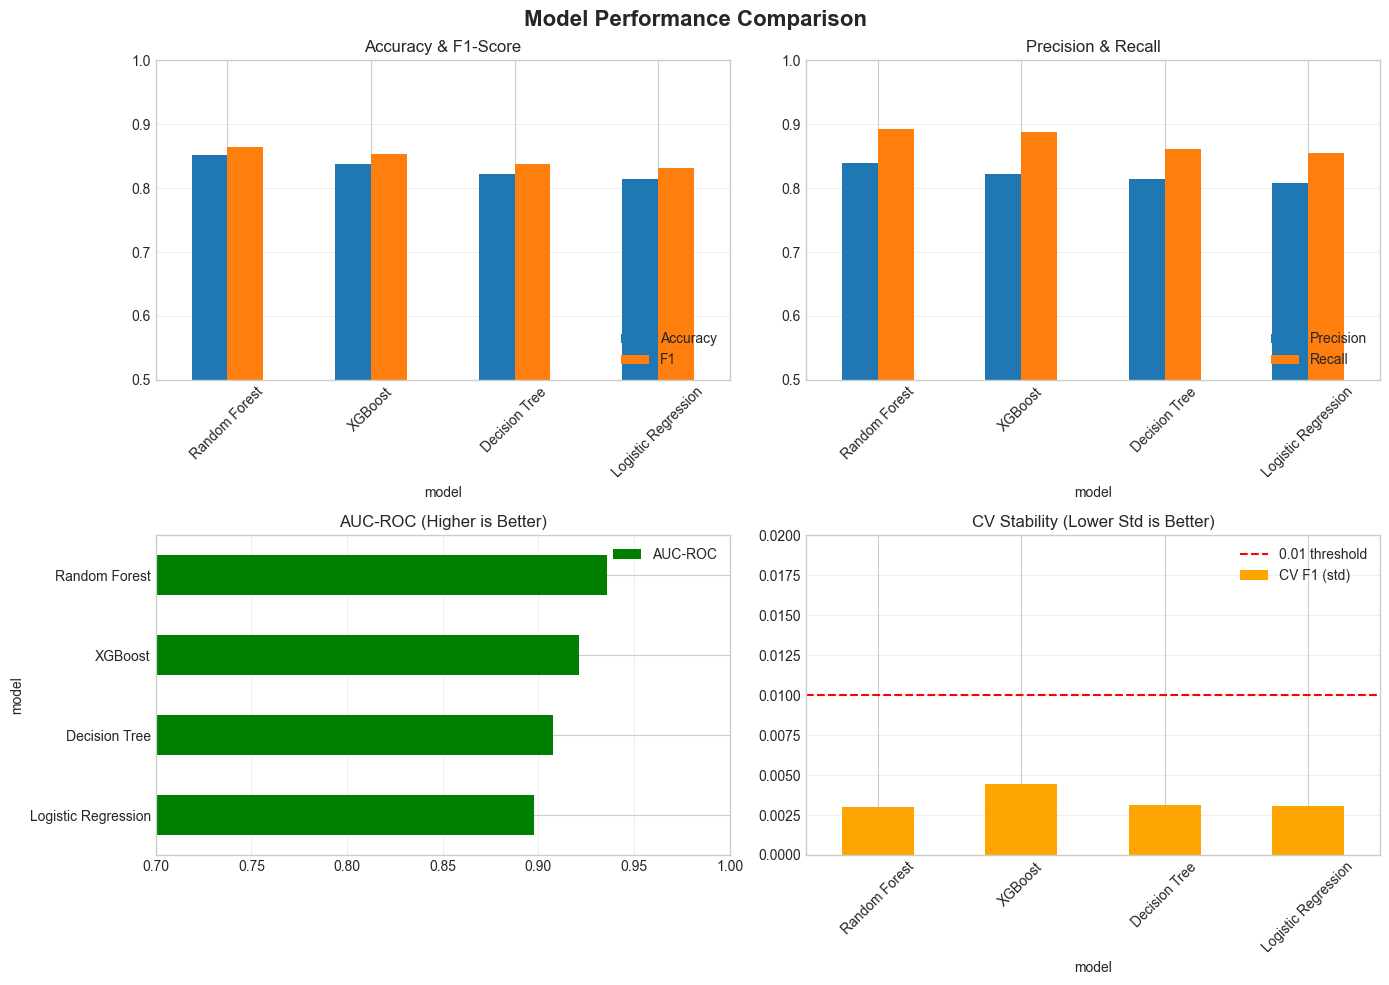

In [12]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy & F1
ax1 = axes[0, 0]
results_df[['Accuracy', 'F1']].plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('Accuracy & F1-Score')
ax1.set_ylim(0.5, 1.0)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# Precision & Recall
ax2 = axes[0, 1]
results_df[['Precision', 'Recall']].plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('Precision & Recall')
ax2.set_ylim(0.5, 1.0)
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)

# AUC-ROC
ax3 = axes[1, 0]
results_df[['AUC-ROC']].sort_values('AUC-ROC').plot(kind='barh', ax=ax3, color='green')
ax3.set_title('AUC-ROC (Higher is Better)')
ax3.set_xlim(0.7, 1.0)
ax3.grid(axis='x', alpha=0.3)

# CV Stability
ax4 = axes[1, 1]
results_df['CV F1 (std)'].plot(kind='bar', ax=ax4, color='orange', rot=45)
ax4.set_title('CV Stability (Lower Std is Better)')
ax4.set_ylim(0, 0.02)
ax4.axhline(y=0.01, color='red', linestyle='--', label='0.01 threshold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Best Model Analysis

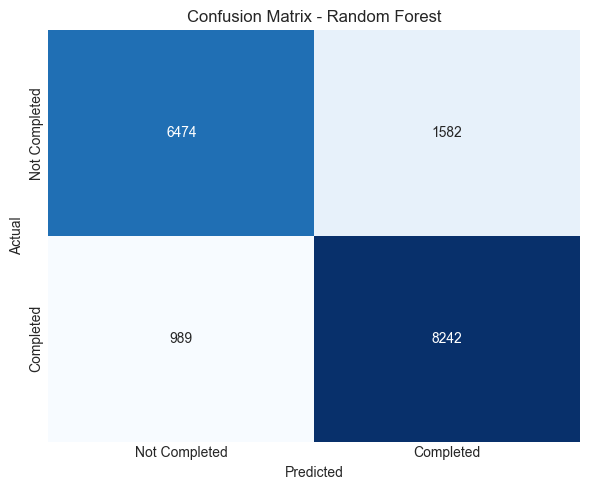


CLASSIFICATION REPORT: Random Forest
               precision    recall  f1-score   support

Not Completed       0.87      0.80      0.83      8056
    Completed       0.84      0.89      0.87      9231

     accuracy                           0.85     17287
    macro avg       0.85      0.85      0.85     17287
 weighted avg       0.85      0.85      0.85     17287



In [13]:
# Get best model predictions
best_model_name = results_df.index[0]
plot_confusion_matrix(y_test, predictions[best_model_name], best_model_name)

# Print classification report
print(f"\n{'='*60}")
print(f"CLASSIFICATION REPORT: {best_model_name}")
print(f"{'='*60}")
print(classification_report(y_test, predictions[best_model_name], 
                          target_names=['Not Completed', 'Completed']))

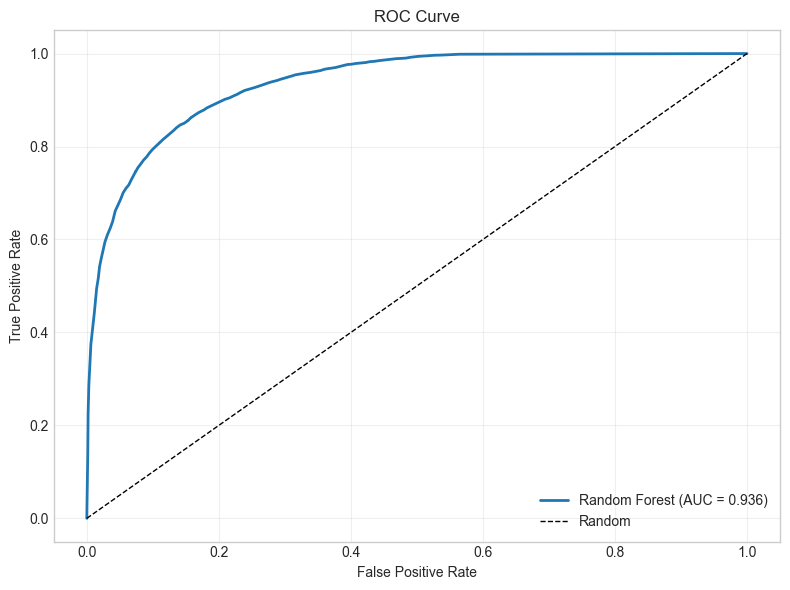

In [14]:
# ROC Curve for best model
plot_roc_curve(y_test, probabilities[best_model_name], best_model_name)

## Feature Importance


TOP 20 FEATURE IMPORTANCE (Random Forest)
                 feature  importance
membership_duration_days    0.172657
                  income    0.122142
                     age    0.104225
                duration    0.092545
              difficulty    0.087086
offer_type_informational    0.074873
           received_time    0.051955
        membership_month    0.050353
  income_bracket_encoded    0.039848
            offer_viewed    0.030124
       age_group_encoded    0.028366
    tenure_group_encoded    0.024715
         membership_year    0.022238
          gender_Missing    0.015276
 is_demographics_missing    0.015269
         offer_type_bogo    0.013507
     offer_type_discount    0.011657
                gender_F    0.010065
               in_social    0.009596
                  in_web    0.009541


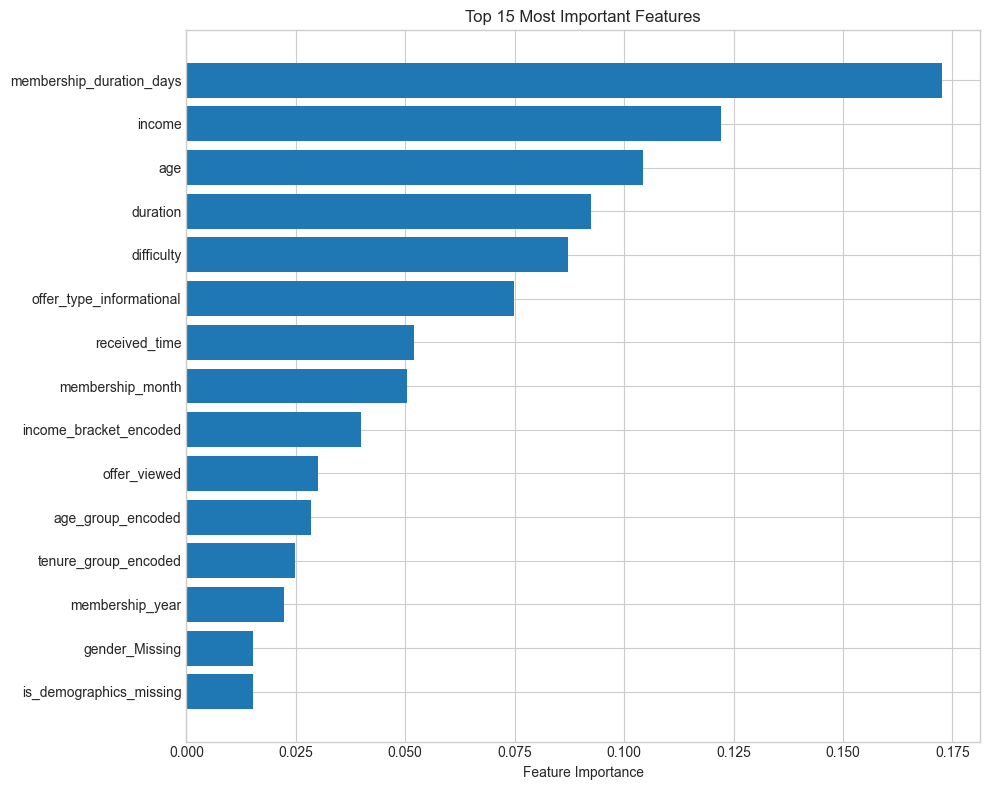

In [15]:
# Feature importance from Random Forest (tree-based model)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    # Use actual column names from X_train (in case features were removed)
    feature_imp_df = pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\n" + "="*60)
    print("TOP 20 FEATURE IMPORTANCE (Random Forest)")
    print("="*60)
    print(feature_imp_df.head(20).to_string(index=False))
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_15 = feature_imp_df.head(15)
    plt.barh(top_15['feature'], top_15['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Random Forest model not available for feature importance")

In [16]:
# Logistic Regression coefficients (for interpretability)
if hasattr(lr_model, 'coef_'):
    # Use actual column names from X_train (in case features were removed)
    coef_df = pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'coefficient': lr_model.coef_[0]
    })
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    
    print("\n" + "="*60)
    print("TOP 15 LOGISTIC REGRESSION COEFFICIENTS")
    print("="*60)
    print("(Positive coef = increases completion probability)")
    print("(Negative coef = decreases completion probability)\n")
    print(coef_df.head(15)[['feature', 'coefficient']].to_string(index=False))


TOP 15 LOGISTIC REGRESSION COEFFICIENTS
(Positive coef = increases completion probability)
(Negative coef = decreases completion probability)

                 feature  coefficient
offer_type_informational    -6.610993
     offer_type_discount     3.212729
         offer_type_bogo     2.645368
            offer_viewed     1.369596
    tenure_group_encoded     1.311403
          gender_Missing    -0.982537
 is_demographics_missing    -0.982537
              difficulty    -0.854820
          offer_received    -0.752896
                in_email    -0.752896
               in_mobile    -0.695782
                  income     0.531588
                duration     0.420266
                gender_O     0.352667
                gender_M    -0.349019


## Hyperparameter Tuning

Tune the best model to improve performance further.

In [17]:
print("="*60)
print("HYPERPARAMETER TUNING: RANDOM FOREST")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [1, 5, 10]
}

print(f"\nParameter grid: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])} combinations")

# Grid search
rf_tuned = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)

grid_search = GridSearchCV(
    rf_tuned,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV... (this may take several minutes)")
grid_search.fit(X_train, y_train)

print(f"\n{'='*60}")
print("TUNING COMPLETE")
print(f"{'='*60}")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
rf_tuned = grid_search.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_test)
rf_tuned_proba = rf_tuned.predict_proba(X_test)[:, 1]

tuned_f1 = f1_score(y_test, rf_tuned_pred)
tuned_auc = roc_auc_score(y_test, rf_tuned_proba)

print(f"\nTuned Model Test Performance:")
print(f"  F1-Score: {tuned_f1:.4f} (baseline: {results_df.loc['Random Forest', 'F1']:.4f})")
print(f"  AUC-ROC:   {tuned_auc:.4f} (baseline: {results_df.loc['Random Forest', 'AUC-ROC']:.4f})")

improvement = (tuned_f1 - results_df.loc['Random Forest', 'F1']) / results_df.loc['Random Forest', 'F1'] * 100
print(f"\nImprovement: {improvement:+.2f}%")

HYPERPARAMETER TUNING: RANDOM FOREST

Parameter grid: 81 combinations

Starting GridSearchCV... (this may take several minutes)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

TUNING COMPLETE

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}
Best CV F1-Score: 0.8532

Tuned Model Test Performance:
  F1-Score: 0.8559 (baseline: 0.8651)
  AUC-ROC:   0.9254 (baseline: 0.9356)

Improvement: -1.06%


## Save Models

Save all trained models for future use.

In [18]:
# Save all models
models_dir = '../Cafe_Rewards_Offers/models'
os.makedirs(models_dir, exist_ok=True)

models_to_save = {
    'logistic_regression.pkl': lr_model,
    'decision_tree.pkl': dt_model,
    'random_forest.pkl': rf_model,
    'random_forest_tuned.pkl': rf_tuned
}

if xgb_model is not None:
    models_to_save['xgboost.pkl'] = xgb_model

for filename, model in models_to_save.items():
    joblib.dump(model, f'{models_dir}/{filename}')
    print(f"✓ Saved: {filename}")

# Save results
results_df.to_csv(f'{models_dir}/model_comparison.csv')
print(f"\n✓ Saved: model_comparison.csv")

print(f"\n{'='*60}")
print("ALL MODELS SAVED")
print(f"{'='*60}")

✓ Saved: logistic_regression.pkl
✓ Saved: decision_tree.pkl
✓ Saved: random_forest.pkl
✓ Saved: random_forest_tuned.pkl
✓ Saved: xgboost.pkl

✓ Saved: model_comparison.csv

ALL MODELS SAVED


## Modeling Summary

**Completed Steps:**
1. ✓ Loaded processed data
2. ✓ Checked for data leakage
3. ✓ Trained 4 baseline/ensemble models
4. ✓ Evaluated using multiple metrics (Accuracy, Precision, Recall, F1, AUC-ROC)
5. ✓ Compared model performance
6. ✓ Identified best performing model
7. ✓ Analyzed feature importance
8. ✓ Performed hyperparameter tuning
9. ✓ Saved all models

**Next Steps:**
1. PCA for dimensionality reduction
2. SHAP analysis for model explainability
3. Bias & fairness analysis
4. Create presentations (technical & business)
5. Upload to GitHub

In [19]:
print("\n" + "="*60)
print("MODELING COMPLETE! ✓")
print("="*60)
print(f"\nBest Model: {best_model}")
print(f"Best F1-Score: {results_df.loc[best_model, 'F1']:.4f}")
print(f"\nAll models saved to: {models_dir}/")


MODELING COMPLETE! ✓

Best Model: Random Forest
Best F1-Score: 0.8651

All models saved to: ../Cafe_Rewards_Offers/models/
